In [1]:
import json

json_chat_history_filepath = 'user_output/query_data.json'

with open(json_chat_history_filepath, 'r') as file:
    data = json.load(file)

In [2]:
data['query_states'][0]

{'query_number': 1,
 'query_text': '1. What is the purpose of tokenizing text into sentences and words?',
 'rag_used': True,
 'history_used': True,
 'rag_and_history_used': True,
 'desired_lookback_window_size': 3,
 'actual_lookback_window_size': 0,
 'bm25': True,
 'query_start_time': '2025-04-29T00:44:08.405420',
 'query_finish_time': '2025-04-29T00:44:14.240076',
 'query_processing_time': 5.834618330001831,
 'context_ids_utilized': [8927, 5489, 4159, 2290, 3113],
 'context_ids_source': ['both', 'both', 'both', 'both', 'both'],
 'current_state_hybrid_fused_scores': [0.027673192771084338,
  0.026333907056798625,
  0.02578981302385558,
  0.024954072259644827,
  0.024404761904761905],
 'response_text': '### 1. Introductory Overview\n\nTokenizing text into sentences and words is a fundamental process in Natural Language Processing (NLP). It\'s like breaking down a complex Lego castle into individual bricks. This decomposition allows computers to understand, analyze, and manipulate text da

In [3]:
data['query_states'][0]

{'query_number': 1,
 'query_text': '1. What is the purpose of tokenizing text into sentences and words?',
 'rag_used': True,
 'history_used': True,
 'rag_and_history_used': True,
 'desired_lookback_window_size': 3,
 'actual_lookback_window_size': 0,
 'bm25': True,
 'query_start_time': '2025-04-29T00:44:08.405420',
 'query_finish_time': '2025-04-29T00:44:14.240076',
 'query_processing_time': 5.834618330001831,
 'context_ids_utilized': [8927, 5489, 4159, 2290, 3113],
 'context_ids_source': ['both', 'both', 'both', 'both', 'both'],
 'current_state_hybrid_fused_scores': [0.027673192771084338,
  0.026333907056798625,
  0.02578981302385558,
  0.024954072259644827,
  0.024404761904761905],
 'response_text': '### 1. Introductory Overview\n\nTokenizing text into sentences and words is a fundamental process in Natural Language Processing (NLP). It\'s like breaking down a complex Lego castle into individual bricks. This decomposition allows computers to understand, analyze, and manipulate text da

In [4]:
query = []
response = []
context_ids = []

for value in data['query_states']:
  query.append(value.get('query_text'))
  response.append(value.get('response_text'))
  context_ids.append(value.get('context_ids_utilized'))

In [5]:
import qdrant_client

In [6]:
import pickle

pkl_filepath = 'qdrant_vector_store/qdrant_vectors.pkl'

# Load the .pkl file
with open(pkl_filepath, "rb") as f:
    vector_data = pickle.load(f)  # This should be a list of dicts with keys: "id", "vector", "payload"

In [7]:
# Extract ids, vectors, and payloads from Record objects
chunk_ids = [record.id for record in vector_data]
chunk_vectors = [record.vector for record in vector_data]
chunk_payloads = [record.payload for record in vector_data]

In [8]:
from itertools import chain

flattened_context_ids = list(chain.from_iterable(context_ids))

In [9]:
len(flattened_context_ids)

50

In [10]:
len(set(flattened_context_ids))

47

In [11]:
len(flattened_context_ids) - len(set(flattened_context_ids))

3

In [12]:
filtered_ids = []
filtered_vectors = []
filtered_payloads = []

for cid, vec, payload in zip(chunk_ids, chunk_vectors, chunk_payloads):
    if cid in set(flattened_context_ids):
        filtered_ids.append(cid)
        filtered_vectors.append(vec)
        filtered_payloads.append(payload)

In [13]:
# Create a dictionary that maps filtered_ids to their corresponding vector and payload
filtered_dict = {}

for cid, vec in zip(filtered_ids, filtered_vectors):
    filtered_dict[cid] = {'id': cid, 'vector': vec}

# Example: Accessing the vector and payload for a specific ID
example_id = flattened_context_ids[0]
if example_id in filtered_dict:
    print(f"Vector: {filtered_dict[example_id]['vector']}")
else:
    print(f"ID {example_id} not found in filtered data.")

Vector: [-0.0012766943546012044, -0.04217147454619408, 0.04647023230791092, 0.004885493312031031, -0.03417579084634781, 0.03285658732056618, 0.030908972024917603, 0.06656993180513382, -0.007079793605953455, -0.010970556177198887, -0.025449387729167938, -0.012614468112587929, 0.031115030869841576, 0.025002703070640564, -0.04415537789463997, 0.02607496827840805, -0.025702552869915962, -0.06014825403690338, -0.08679752796888351, -0.07008156925439835, -0.011084867641329765, 0.0073167080990970135, 0.005293761380016804, 0.0737450048327446, 0.01072172075510025, 0.0005099844420328736, 0.007025479339063168, -0.06020604819059372, 0.043980102986097336, 0.00618546549230814, -0.02163189835846424, 0.01190682128071785, 0.07079451531171799, 0.022125674411654472, 0.009579241275787354, -0.018500905483961105, 0.05833617225289345, -0.03430193290114403, -0.03784659132361412, 0.01720578223466873, 0.020051678642630577, 0.019526101648807526, 0.014849528670310974, -0.030842699110507965, 0.01892836019396782, 0.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_multi_step_max_similarity3(
    context_ids,
    filtered_dict,
    step_labels=None,
    start_step=0,
    end_step=None,
    min_similarity=0.0
):
    """
    Plots max-cosine-similarity connections for chunks from step i to step i+1,
    annotated with similarity weights, across a specified slice of steps.

    Parameters:
    - context_ids: List[List[int]], list of chunk-ID lists per step
    - filtered_dict: { cid: {'vector': np.ndarray, ...}, ... }
    - step_labels: Optional[List[str]], custom labels per step
    - start_step: int, index of the first step to include
    - end_step: Optional[int], index of the last step to include (inclusive)
    - min_similarity: float, minimum cosine similarity threshold to draw an edge
    """
    total_steps = len(context_ids)
    if end_step is None or end_step >= total_steps:
        end_step = total_steps - 1
    if start_step < 0 or start_step > end_step:
        raise ValueError("start_step must be between 0 and end_step")

    # Slice steps
    slice_ids = context_ids[start_step:end_step+1]
    # Build labels
    if step_labels:
        slice_labels = step_labels[start_step:end_step+1]
    else:
        slice_labels = [f"Step {i}" for i in range(start_step, end_step+1)]

    num_steps = len(slice_ids)
    x_positions = list(range(num_steps))
    y_positions = {i: list(range(len(slice_ids[i]))) for i in range(num_steps)}

    fig, ax = plt.subplots(figsize=(14, 6))
    cmap = plt.get_cmap('viridis')

    # Plot nodes and labels
    for i, step_ids in enumerate(slice_ids):
        xs = [x_positions[i]] * len(step_ids)
        ys = y_positions[i]
        ax.scatter(xs, ys, color=f"C{i}", s=100, label=slice_labels[i], edgecolor='k')
        for y, cid in zip(ys, step_ids):
            ax.text(x_positions[i], y, str(cid), va='center', ha='center', fontsize=8)

    # Plot edges between consecutive sliced steps
    for i in range(num_steps - 1):
        ids_a = slice_ids[i]
        ids_b = slice_ids[i + 1]
        vec_a = np.vstack([filtered_dict[cid]['vector'] for cid in ids_a])
        vec_b = np.vstack([filtered_dict[cid]['vector'] for cid in ids_b])
        sim_mat = cosine_similarity(vec_a, vec_b)
        best_indices = sim_mat.argmax(axis=1)
        best_sims = sim_mat.max(axis=1)

        for idx_a, cid_a in enumerate(ids_a):
            sim = best_sims[idx_a]
            if sim < min_similarity:
                continue  # skip edges below threshold
            idx_b = best_indices[idx_a]
            x0, y0 = x_positions[i], y_positions[i][idx_a]
            x1, y1 = x_positions[i + 1], y_positions[i + 1][idx_b]
            color = cmap(sim)
            lw = 1 + 2 * sim
            ax.plot([x0, x1], [y0, y1], color=color, linewidth=lw, alpha=0.8)
            xm, ym = (x0 + x1) / 2, (y0 + y1) / 2
            ax.text(
                xm, ym, f"{sim:.2f}",
                ha='center', va='center',
                fontsize=7, backgroundcolor='white', alpha=0.6
            )

    # Formatting
    ax.set_xticks(x_positions)
    ax.set_xticklabels(slice_labels)
    ax.set_yticks([])
    ax.set_title(f"Max-Cosine-Similarity Connections\n(minimum edge similarity ≥ {min_similarity})")
    ax.set_xlim(-0.5, num_steps - 0.5)
    max_len = max(len(step) for step in slice_ids)
    ax.set_ylim(-1, max_len)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_multi_step_max_similarity(context_ids, filtered_dict, start_step=0, end_step=3, min_similarity=0.5)

In [15]:
len(data['query_states'])

10

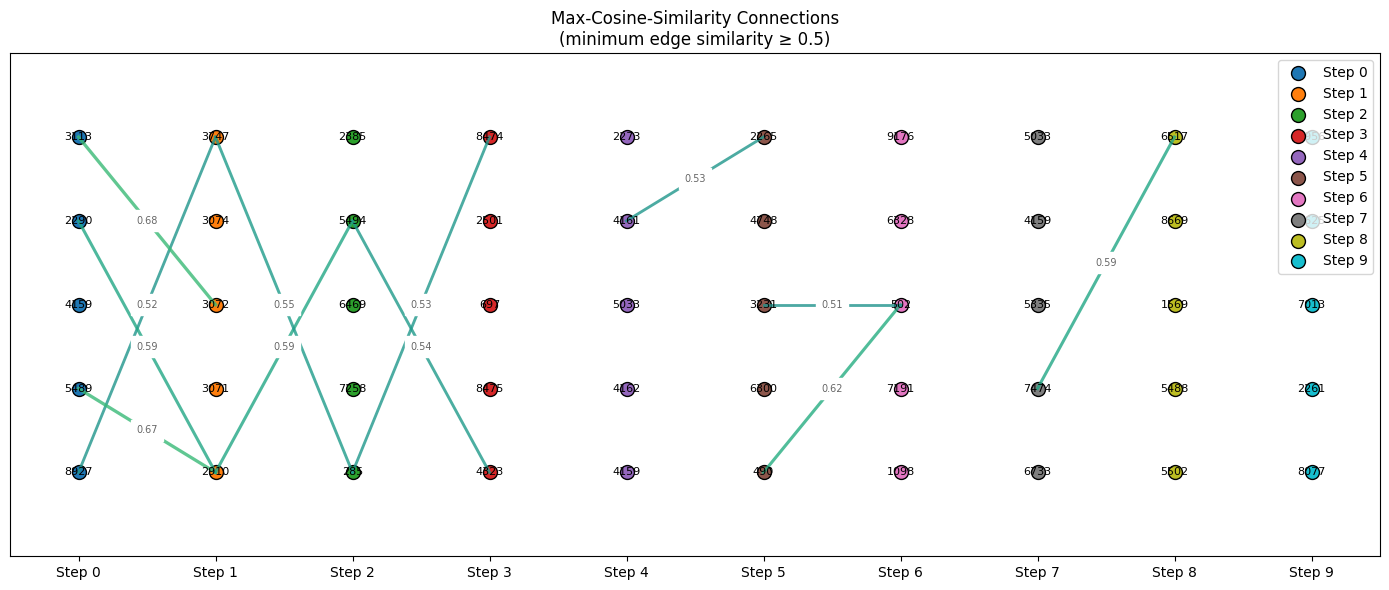

In [16]:
for i in range(0, len(data['query_states']), 10):
    plot_multi_step_max_similarity3(context_ids, filtered_dict, start_step=i, end_step=i + 10, min_similarity=0.5)

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# === Replace with your actual context_ids and filtered_dict ===
# context_ids: List[List[int]] of chunk IDs per time step
# filtered_dict: { cid: {'vector': np.ndarray, ...}, ... }

# Example definitions (comment out when using real data)
# context_ids = [
#     [6451, 6329, 1528, ...],
#     [3753, 9232, 3752, ...],
#     ...
# ]
# filtered_dict = {
#     6451: {'vector': np.array([...])},
#     6329: {'vector': np.array([...])},
#     ...
# }

# 1. Compute centroid embedding per time step
centroids = []
for step_ids in context_ids:
    vectors = np.vstack([filtered_dict[cid]['vector'] for cid in step_ids])
    centroids.append(vectors.mean(axis=0))

centroids = np.array(centroids)

# 2. Normalize centroids for cosine similarity
norms = np.linalg.norm(centroids, axis=1, keepdims=True)
centroids_normed = centroids / np.clip(norms, 1e-8, None)

# 3. Compute pairwise cosine similarity matrix
sim_matrix = cosine_similarity(centroids_normed)

# 4. Build DataFrame with appropriate labels
labels = [f"Step {i}" for i in range(len(centroids))]
df_similarity = pd.DataFrame(sim_matrix, index=labels, columns=labels)

display(df_similarity)

,Step 0,Step 1,Step 2,Step 3,Step 4,Step 5,Step 6,Step 7,Step 8,Step 9
Step 0,1.000000,0.782268,0.704351,0.636409,0.721412,0.728022,0.647372,0.744529,0.791722,0.649558
Step 1,0.782268,1.000000,0.585949,0.568129,0.494924,0.689078,0.603933,0.583612,0.680165,0.552243
Step 2,0.704351,0.585949,1.000000,0.749585,0.587192,0.564743,0.610644,0.763301,0.789473,0.621389
Step 3,0.636409,0.568129,0.749585,1.000000,0.492541,0.547515,0.620573,0.672416,0.706543,0.662371
Step 4,0.721412,0.494924,0.587192,0.492541,1.000000,0.566289,0.533811,0.772693,0.598156,0.549434
Step 5,0.728022,0.689078,0.564743,0.547515,0.566289,1.000000,0.657003,0.582276,0.636754,0.633881
Step 6,0.647372,0.603933,0.610644,0.620573,0.533811,0.657003,1.000000,0.630590,0.626475,0.632821
Step 7,0.744529,0.583612,0.763301,0.672416,0.772693,0.582276,0.630590,1.000000,0.734890,0.634505
Step 8,0.791722,0.680165,0.789473,0.706543,0.598156,0.636754,0.626475,0.734890,1.000000,0.648943
Step 9,0.649558,0.552243,0.621389,0.662371,0.549434,0.633881,0.632821,0.634505,0.648943,1.000000


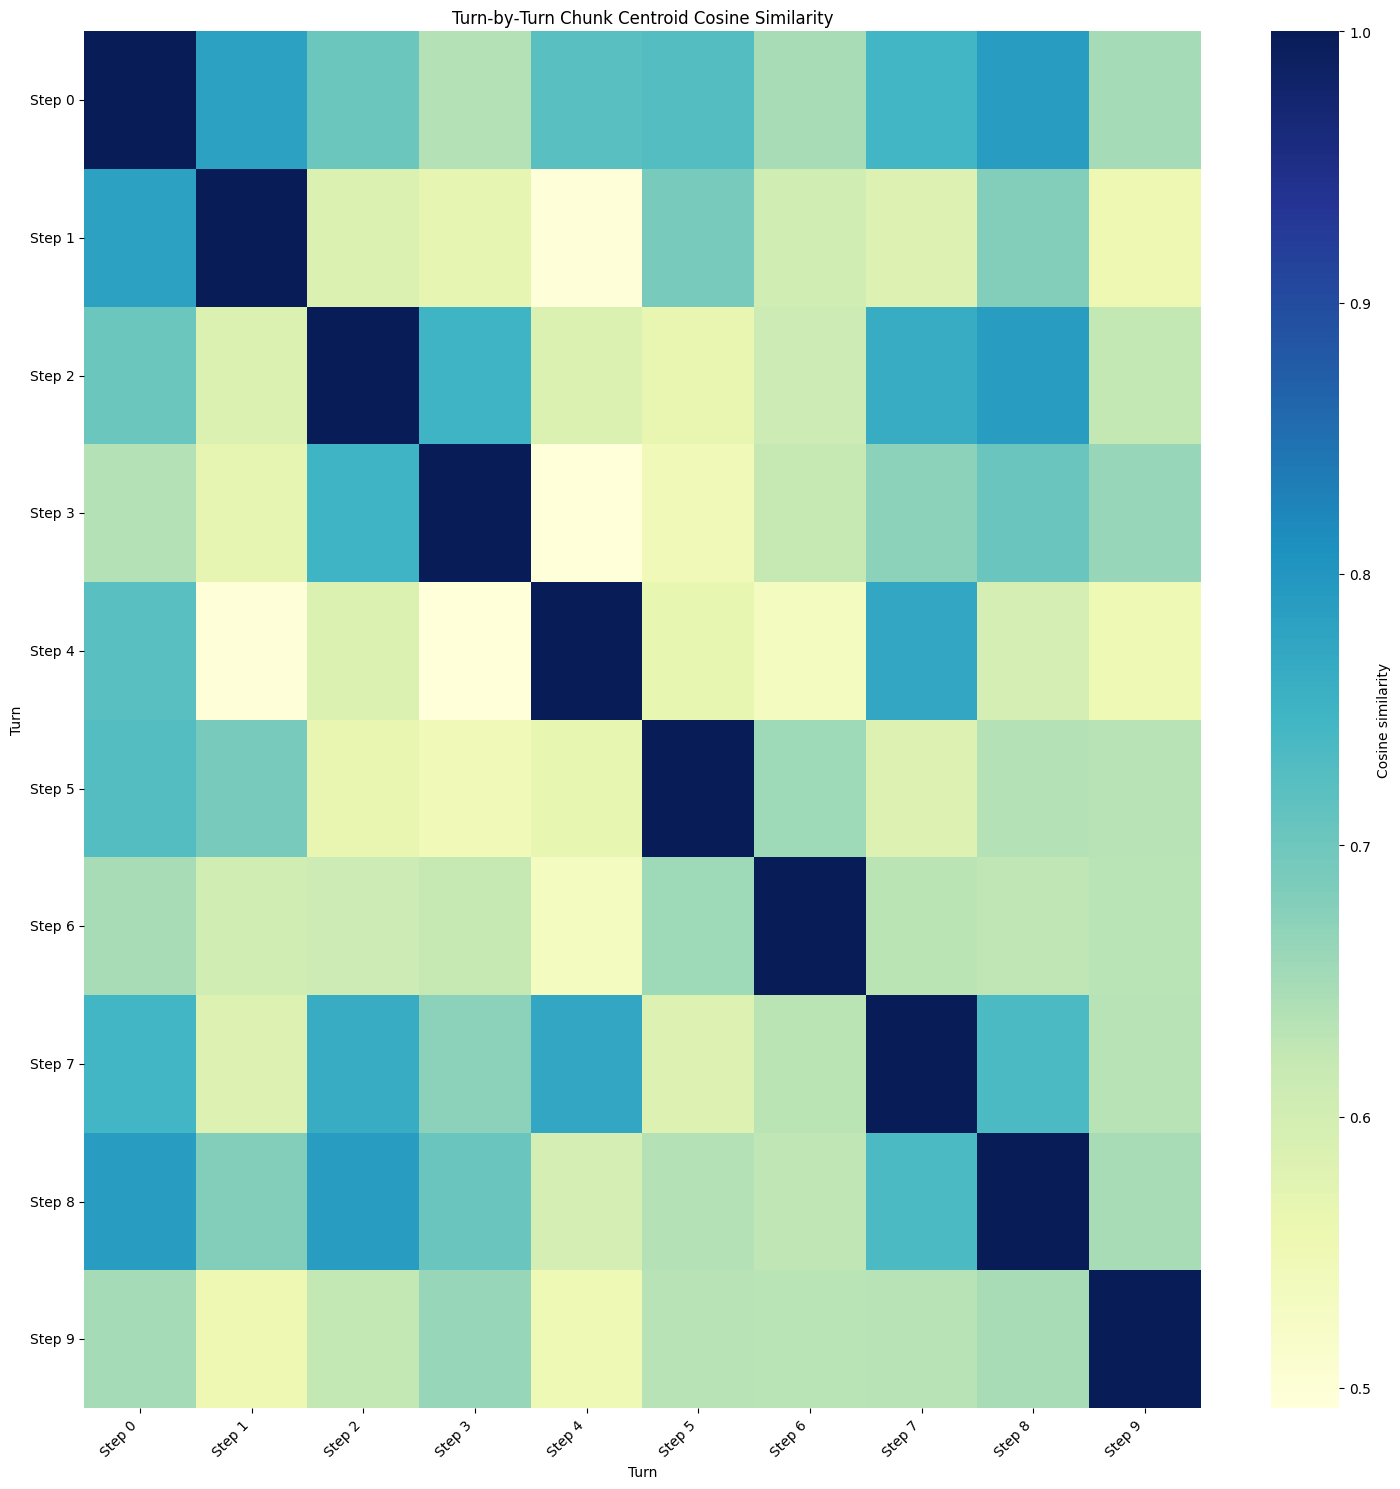

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.heatmap(
    df_similarity,
    cmap="YlGnBu",       # or another sequential colormap
    #annot=False,         # don't show the numbers in each cell
    #fmt=".2f",           # two‐decimal formatting
    cbar_kws={"label": "Cosine similarity"}
)
plt.title("Turn‑by‑Turn Chunk Centroid Cosine Similarity")
plt.xlabel("Turn")
plt.ylabel("Turn")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

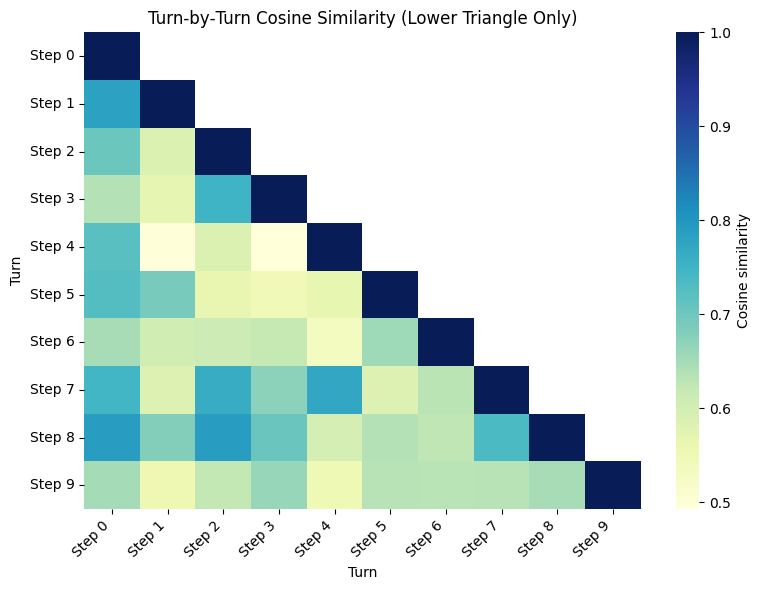

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# build a boolean mask for the upper triangle (k=1 excludes the diagonal)
mask = np.triu(np.ones(df_similarity.shape, dtype=bool), k=1)

plt.figure(figsize=(8, 6))
sns.heatmap(
    df_similarity,
    mask=mask,
    cmap="YlGnBu",
    cbar_kws={"label": "Cosine similarity"}
)
plt.title("Turn‑by‑Turn Cosine Similarity (Lower Triangle Only)")
plt.xlabel("Turn")
plt.ylabel("Turn")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import pandas as pd

def detect_conversation_flow(
    df_similarity: pd.DataFrame,
    continuation_threshold: float = 0.8,
    callback_threshold: float = None
) -> pd.DataFrame:
    """
    Label each turn as Start, Continuation, Callback, or Shift based on thresholds.

    Parameters:
    - df_similarity: square DataFrame of cosine similarities between turn centroids.
                     Index and columns should be identical labels for each step.
    - continuation_threshold: similarity to previous turn required for 'Continuation'.
    - callback_threshold: similarity to any earlier non-adjacent turn required for 'Callback'.
                          If None, defaults to continuation_threshold.

    Returns:
    - DataFrame with columns:
        Turn, Similarity_to_Previous, Best_Earlier_Similarity,
        Best_Earlier_Turn, Flow_Label
    """
    if callback_threshold is None:
        callback_threshold = continuation_threshold

    steps = df_similarity.index.tolist()
    records = []

    for i, step in enumerate(steps):
        if i == 0:
            records.append({
                'Turn': step,
                'Similarity_to_Previous': np.nan,
                'Best_Earlier_Similarity': np.nan,
                'Best_Earlier_Turn': None,
                'Flow_Label': 'Start'
            })
            continue

        prev = steps[i - 1]
        sim_prev = df_similarity.at[step, prev]

        if sim_prev >= continuation_threshold:
            flow = 'Continuation'
            best_sim = sim_prev
            best_turn = prev
        else:
            earlier = steps[:i - 1]
            if earlier:
                sims = df_similarity.loc[step, earlier]
                best_sim = sims.max()
                best_turn = sims.idxmax()
                if best_sim >= callback_threshold:
                    flow = f'Callback to {best_turn}'
                else:
                    flow = 'Shift'
            else:
                best_sim = np.nan
                best_turn = None
                flow = 'Shift'

        records.append({
            'Turn': step,
            'Similarity_to_Previous': sim_prev,
            'Best_Earlier_Similarity': best_sim,
            'Best_Earlier_Turn': best_turn,
            'Flow_Label': flow
        })

    df_flow = pd.DataFrame(records)
    return df_flow

# Example usage:
# Assuming df_similarity is already in your namespace
# df_flow = detect_conversation_flow(df_similarity, continuation_threshold=0.8, callback_threshold=0.75)

In [21]:
df_flow = detect_conversation_flow(df_similarity, continuation_threshold=0.6, callback_threshold=0.6)
df_flow

,Turn,Similarity_to_Previous,Best_Earlier_Similarity,Best_Earlier_Turn,Flow_Label
0,Step 0,NaN,NaN,None,Start
1,Step 1,0.782268,0.782268,Step 0,Continuation
2,Step 2,0.585949,0.704351,Step 0,Callback to Step 0
3,Step 3,0.749585,0.749585,Step 2,Continuation
4,Step 4,0.492541,0.721412,Step 0,Callback to Step 0
5,Step 5,0.566289,0.728022,Step 0,Callback to Step 0
6,Step 6,0.657003,0.657003,Step 5,Continuation
7,Step 7,0.630590,0.630590,Step 6,Continuation
8,Step 8,0.734890,0.734890,Step 7,Continuation
9,Step 9,0.648943,0.648943,Step 8,Continuation


In [22]:
import numpy as np
import pandas as pd

def detect_flow_with_blocks(
    df_similarity: pd.DataFrame,
    T_cont: float = 0.8,
    T_cb:    float = None
) -> pd.DataFrame:
    """
    Labels each turn as Start, Continuation, Callback, or Shift,
    using a 'continuation block' so callbacks only consider
    turns *before* the current block.
    """
    if T_cb is None:
        T_cb = T_cont

    steps = df_similarity.index.tolist()
    records = []

    block_start = 0  # first turn of the active continuation block

    for t, step in enumerate(steps):
        if t == 0:
            # first turn
            records.append({
                'Turn': step,
                'Similarity_to_Previous': np.nan,
                'Best_Earlier_Sim':     np.nan,
                'Best_Earlier_Turn':    None,
                'Flow':                 'Start'
            })
            continue

        # sim to immediately previous turn
        prev = steps[t-1]
        sim_prev = df_similarity.at[step, prev]

        if sim_prev >= T_cont:
            # continuation within current block
            flow = 'Continuation'
            best_sim = sim_prev
            best_turn = prev
            # block_start stays the same

        else:
            # look only at turns *before* the current block
            candidates = steps[:block_start]
            if candidates:
                sims_earlier = df_similarity.loc[step, candidates]
                best_sim = sims_earlier.max()
                best_turn = sims_earlier.idxmax()
                if best_sim >= T_cb:
                    flow = f'Callback to {best_turn}'
                    # block_start unchanged
                else:
                    flow = 'Shift'
                    block_start = t  # start a fresh block here
            else:
                # no earlier candidates → it's a shift
                best_sim = np.nan
                best_turn = None
                flow = 'Shift'
                block_start = t

        records.append({
            'Turn': step,
            'Similarity_to_Previous': sim_prev,
            'Best_Earlier_Sim':     best_sim,
            'Best_Earlier_Turn':    best_turn,
            'Flow':                 flow
        })

    return pd.DataFrame(records)

In [23]:
df_flow = detect_flow_with_blocks(df_similarity, T_cont=0.8, T_cb=0.75)
display(df_flow)

,Turn,Similarity_to_Previous,Best_Earlier_Sim,Best_Earlier_Turn,Flow
0,Step 0,NaN,NaN,None,Start
1,Step 1,0.782268,NaN,None,Shift
2,Step 2,0.585949,0.704351,Step 0,Shift
3,Step 3,0.749585,0.636409,Step 0,Shift
4,Step 4,0.492541,0.721412,Step 0,Shift
5,Step 5,0.566289,0.728022,Step 0,Shift
6,Step 6,0.657003,0.647372,Step 0,Shift
7,Step 7,0.630590,0.772693,Step 4,Callback to Step 4
8,Step 8,0.734890,0.791722,Step 0,Callback to Step 0
9,Step 9,0.648943,0.662371,Step 3,Shift


In [24]:
import numpy as np
import pandas as pd

def detect_flow_with_blocks2(
    df_similarity: pd.DataFrame,
    T_cont: float = 0.8,
    T_cb:    float = None
) -> pd.DataFrame:
    """
    Label each turn in a conversation as Start, Continuation, Callback, or Shift
    based on centroid cosine similarities and a “continuation block” heuristic.

    Parameters:
        df_similarity (pd.DataFrame):
            Square matrix of cosine similarities between turn centroids.
            Rows and columns are identical turn labels (e.g. “Step 0”, “Step 1”, …).
        T_cont (float):
            Threshold for “continuation”—if sim(current, previous) ≥ T_cont, we stay
            in the same topic block.
        T_cb (float or None):
            Threshold for “callback”—if not a continuation, and the best similarity
            to any turn *before* the current block_start ≥ T_cb, we label a callback.
            If None, defaults to T_cont.

    Local variables:
        steps (List[str]):
            Ordered list of turn labels from df_similarity.index.
        records (List[dict]):
            Accumulates one dict per turn, with fields:
                - 'Turn', 'Similarity_to_Previous', 'Best_Earlier_Sim',
                  'Best_Earlier_Turn', 'Flow'.
        block_start (int):
            Index of the first turn in the active continuation block. Callbacks only
            consider turns with index < block_start.
        t (int):
            Loop index for the current turn (0-based).
        step (str):
            Label of the current turn (e.g. “Step 3”).
        prev (str):
            Label of the immediately preceding turn (steps[t-1]).
        sim_prev (float):
            Cosine similarity between the current turn and prev turn.
        all_earlier (List[str]):
            List of all prior turn labels (steps[:t]).
        sims_all (pd.Series):
            Similarities between the current turn and all earlier turns.
        best_overall_sim (float):
            Maximum value in sims_all (guaranteed ≥ sim_prev).
        best_overall_turn (str):
            Label of the turn achieving best_overall_sim.
        external (List[str]):
            List of turn labels outside the current continuation block
            (steps[:block_start]), used for callback detection.
        sims_ext (pd.Series):
            Similarities between the current turn and external turns.
        best_ext_sim (float):
            Maximum value in sims_ext.
        best_ext_turn (str):
            Label of the turn achieving best_ext_sim.
        flow (str):
            Final label for the current turn: one of
            “Start”, “Continuation”, “Callback to <turn>”, or “Shift”.

    Returns:
        pd.DataFrame
            Table with one row per turn and columns:
            ['Turn', 'Similarity_to_Previous', 'Best_Earlier_Sim',
            'Best_Earlier_Turn', 'Flow'].
    """

    if T_cb is None:
        T_cb = T_cont

    steps = df_similarity.index.tolist()
    records = []
    block_start = 0  # index of first turn in the current continuation block

    for t, step in enumerate(steps):
        if t == 0:
            records.append({
                'Turn': step,
                'Similarity_to_Previous': np.nan,
                'Best_Earlier_Sim':     np.nan,  # overall best
                'Best_Earlier_Turn':    None,
                'Flow':                 'Start'
            })
            continue

        # 1. sim to immediate predecessor
        prev = steps[t-1]
        sim_prev = df_similarity.at[step, prev]

        # 2. overall best similarity to any earlier turn j < t
        all_earlier = steps[:t]
        sims_all = df_similarity.loc[step, all_earlier]
        best_overall_sim = sims_all.max()
        best_overall_turn = sims_all.idxmax()

        # 3. decide flow using only external sims (j < block_start)
        if sim_prev >= T_cont:
            flow = 'Continuation'
            # block_start unchanged
        else:
            external = steps[:block_start]
            if external:
                sims_ext = df_similarity.loc[step, external]
                best_ext_sim = sims_ext.max()
                best_ext_turn = sims_ext.idxmax()
                if best_ext_sim >= T_cb:
                    flow = f'Callback to {best_ext_turn}'
                else:
                    flow = 'Shift'
                    block_start = t
            else:
                flow = 'Shift'
                block_start = t

        records.append({
            'Turn': step,
            'Similarity_to_Previous': sim_prev,
            'Best_Earlier_Sim':       best_overall_sim,
            'Best_Earlier_Turn':      best_overall_turn,
            'Flow':                   flow
        })

    return pd.DataFrame(records)

In [25]:
df_flow2 = detect_flow_with_blocks2(df_similarity, T_cont=0.8, T_cb=0.75)
display(df_flow2)

,Turn,Similarity_to_Previous,Best_Earlier_Sim,Best_Earlier_Turn,Flow
0,Step 0,NaN,NaN,None,Start
1,Step 1,0.782268,0.782268,Step 0,Shift
2,Step 2,0.585949,0.704351,Step 0,Shift
3,Step 3,0.749585,0.749585,Step 2,Shift
4,Step 4,0.492541,0.721412,Step 0,Shift
5,Step 5,0.566289,0.728022,Step 0,Shift
6,Step 6,0.657003,0.657003,Step 5,Shift
7,Step 7,0.630590,0.772693,Step 4,Callback to Step 4
8,Step 8,0.734890,0.791722,Step 0,Callback to Step 0
9,Step 9,0.648943,0.662371,Step 3,Shift


In [26]:
import numpy as np
import pandas as pd

def detect_flow_relative(
    df_similarity: pd.DataFrame,
    drop_threshold: float,
    callback_threshold: float = None
) -> pd.DataFrame:
    """
    Label each turn as Start, Continuation, Callback, or Shift using
    Relative Drop/Rise Detection on the similarity-to-previous series.

    Parameters:
        df_similarity (pd.DataFrame):
            Square matrix of cosine similarities between turn centroids.
            Rows and columns labeled identically (e.g. "Step 0", "Step 1", ...).
        drop_threshold (float):
            Maximum allowed drop in sim_to_previous before suspecting a change.
            If Δ = sim(t, t-1) - sim(t-1, t-2) ≥ -drop_threshold, label Continuation.
        callback_threshold (float, optional):
            Similarity threshold for Callback detection when a large drop occurs.
            Defaults to drop_threshold if None.

    Returns:
        pd.DataFrame:
            Columns: ['Turn', 'sim_to_prev', 'delta',
                      'best_earlier_sim', 'best_earlier_turn', 'Flow']
    """
    if callback_threshold is None:
        callback_threshold = drop_threshold

    steps = df_similarity.index.tolist()
    N = len(steps)

    # 1. Compute similarity to previous turn
    sim_to_prev = [np.nan] * N
    for t in range(1, N):
        sim_to_prev[t] = df_similarity.at[steps[t], steps[t-1]]

    records = []
    for t in range(N):
        step = steps[t]
        if t == 0:
            records.append({
                'Turn': step,
                'sim_to_prev': np.nan,
                'delta':      np.nan,
                'best_earlier_sim':    np.nan,
                'best_earlier_turn':   None,
                'Flow':       'Start'
            })
            continue

        sim_prev = sim_to_prev[t]
        if t == 1:
            delta = np.nan
            # Only one earlier turn to consider
            best_earlier_sim = sim_prev
            best_earlier_turn = steps[0]
            if sim_prev >= drop_threshold:
                flow = 'Continuation'
            elif sim_prev >= callback_threshold:
                flow = f'Callback to {best_earlier_turn}'
            else:
                flow = 'Shift'
        else:
            delta = sim_prev - sim_to_prev[t-1]
            if delta >= -drop_threshold:
                # small drop or rise => continuation
                flow = 'Continuation'
                best_earlier_sim = sim_prev
                best_earlier_turn = steps[t-1]
            else:
                # large drop => check callbacks among earlier turns j <= t-2
                earlier = steps[:t-1]
                sims_earlier = df_similarity.loc[step, earlier]
                best_earlier_sim = sims_earlier.max()
                best_earlier_turn = sims_earlier.idxmax()
                if best_earlier_sim >= callback_threshold:
                    flow = f'Callback to {best_earlier_turn}'
                else:
                    flow = 'Shift'

        records.append({
            'Turn': step,
            'sim_to_prev': sim_prev,
            'delta':      delta,
            'best_earlier_sim':  best_earlier_sim,
            'best_earlier_turn': best_earlier_turn,
            'Flow':       flow
        })

    return pd.DataFrame(records)

# Example usage:
# df_flow = detect_flow_relative(df_similarity, drop_threshold=0.1, callback_threshold=0.8)
# print(df_flow)


In [27]:
df_relative_flow = detect_flow_relative(df_similarity, drop_threshold=0.2, callback_threshold=0.75)
display(df_relative_flow)

,Turn,sim_to_prev,delta,best_earlier_sim,best_earlier_turn,Flow
0,Step 0,NaN,NaN,NaN,None,Start
1,Step 1,0.782268,NaN,0.782268,Step 0,Continuation
2,Step 2,0.585949,-0.196319,0.585949,Step 1,Continuation
3,Step 3,0.749585,0.163636,0.749585,Step 2,Continuation
4,Step 4,0.492541,-0.257044,0.721412,Step 0,Shift
5,Step 5,0.566289,0.073748,0.566289,Step 4,Continuation
6,Step 6,0.657003,0.090714,0.657003,Step 5,Continuation
7,Step 7,0.630590,-0.026413,0.630590,Step 6,Continuation
8,Step 8,0.734890,0.104300,0.734890,Step 7,Continuation
9,Step 9,0.648943,-0.085947,0.648943,Step 8,Continuation


In [28]:
import re

def process_queries_by_flow(queries, df_flow, turn_label_prefix="Step"):
    """
    Print queries organized by conversation flow:
      - Continuation blocks (consecutive "Continuation" steps)
      - Callback pairs ("Callback to Step X")
      - Shift windows (step X-1, X, X+1 for "Shift")

    Parameters:
        queries (List[str]): List of query strings in chronological order.
        df_flow (pd.DataFrame): DataFrame with columns ['Turn', 'Flow'] matching queries.
        turn_label_prefix (str): Prefix in 'Turn' labels, e.g. "Step".
    """
    N = len(queries)
    cont_block = []

    def flush_cont_block():
        if len(cont_block) > 1:
            start, end = cont_block[0], cont_block[-1]
            print(f"\nContinuation block from {turn_label_prefix} {start} to {turn_label_prefix} {end}:")
            for idx in cont_block:
                print(f"  {turn_label_prefix} {idx}: {queries[idx]}")
        cont_block.clear()

    for i in range(N):
        flow = df_flow.loc[i, 'Flow']

        # Continuation
        if flow == "Continuation":
            cont_block.append(i)
            continue

        # On break from continuation
        flush_cont_block()

        # Callback
        if flow.startswith("Callback"):
            # Extract referenced step number
            match = re.search(r"Step\s+(\d+)", flow)
            if match:
                ref = int(match.group(1))
                print(f"\nCallback at {turn_label_prefix} {i}: {queries[i]}")
                print(f"  references {turn_label_prefix} {ref}: {queries[ref]}")
            else:
                print(f"\n{flow} at {turn_label_prefix} {i}: {queries[i]}")

        # Shift
        elif flow == "Shift":
            start = max(0, i - 1)
            end = min(N - 1, i + 1)
            print(f"\nShift window centered at {turn_label_prefix} {i}:")
            for idx in range(start, end + 1):
                label = " (center)" if idx == i else ""
                print(f"  {turn_label_prefix} {idx}{label}: {queries[idx]}")

        # Start or other
        else:
            print(f"\n{flow} at {turn_label_prefix} {i}: {queries[i]}")

    # Flush any trailing continuation block
    flush_cont_block()

# Example usage:
# process_queries_by_flow(query_list, df_flow)

In [29]:
process_queries_by_flow(query, df_relative_flow)


Start at Step 0: 1. What is the purpose of tokenizing text into sentences and words?

Continuation block from Step 1 to Step 3:
  Step 1: 2. What are n-gram language models and how are they useful in NLP?
  Step 2: 3. What is the naive Bayes assumption and how does it relate to text classificatIon?
  Step 3: 4. What are some of the advantages and disadvantages of naive Bayes classifiers compared to logistic regression?

Shift window centered at Step 4:
  Step 3: 4. What are some of the advantages and disadvantages of naive Bayes classifiers compared to logistic regression?
  Step 4 (center): 5. What do we mean by "features" in the context of text classification? Give some examples of features that might be useful for distinguishing different newsgroup topics.
  Step 5: 6. What is the purpose of a test set in machine learning? Why do we need separatetraining and test sets?

Continuation block from Step 5 to Step 9:
  Step 5: 6. What is the purpose of a test set in machine learning? Why

In [30]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from IPython.display import display

def cluster_turn_centroids(
    centroids: np.ndarray,
    turn_labels: list,
    n_clusters: int = 3
) -> pd.DataFrame:
    """
    Cluster turn‐centroid embeddings into topic states.

    Parameters:
      centroids (np.ndarray): array of shape (N_turns, embedding_dim) of centroid vectors.
      turn_labels (List[str]): list of length N_turns, labels like ["Step 0", "Step 1", ...].
      n_clusters (int): number of clusters (topics) for KMeans.

    Returns:
      pd.DataFrame: with columns ['Turn', 'Cluster'], cluster label per turn.
    """
    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(centroids)

    # Build and display DataFrame
    df_clusters = pd.DataFrame({'Turn': turn_labels, 'Cluster': labels})
    display(df_clusters)

    return df_clusters

# Example usage:
turn_labels = [f"Step {i}" for i in range(len(centroids))]
df_clusters = cluster_turn_centroids(centroids_normed, turn_labels, n_clusters=2)

,Turn,Cluster
0,Step 0,0
1,Step 1,0
2,Step 2,1
3,Step 3,1
4,Step 4,0
5,Step 5,0
6,Step 6,1
7,Step 7,1
8,Step 8,1
9,Step 9,1


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

def visualize_clusters_tsne_with_adjusttext(centroids: np.ndarray, df_clusters: pd.DataFrame, perplexity=30):
    """
    t-SNE projection colored by cluster, with labels adjusted to avoid overlap using adjustText.
    """
    # 1. t-SNE projection to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    coords = tsne.fit_transform(centroids)

    # 2. Scatter plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        coords[:, 0], coords[:, 1],
        c=df_clusters['Cluster'],
        cmap='tab10',
        s=100,
        edgecolors='k'
    )

    # 3. Create text objects without worrying about overlap yet
    texts = []
    for i, turn_label in enumerate(df_clusters['Turn']):
        txt = plt.text(
            coords[i, 0], coords[i, 1], turn_label,
            fontsize=9, ha='center', va='center'
        )
        texts.append(txt)

    # 4. Adjust to minimize overlaps, drawing faint leader lines
    adjust_text(
        texts,
        only_move={'texts': 'xy', 'points': 'none'},
        arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5)
    )

    # 5. Legend and axes labels
    plt.title("t-SNE Clusters with Non-Overlapping Labels")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    handles, labels = scatter.legend_elements()
    plt.legend(handles, labels, title="Cluster")
    plt.tight_layout()
    plt.show()

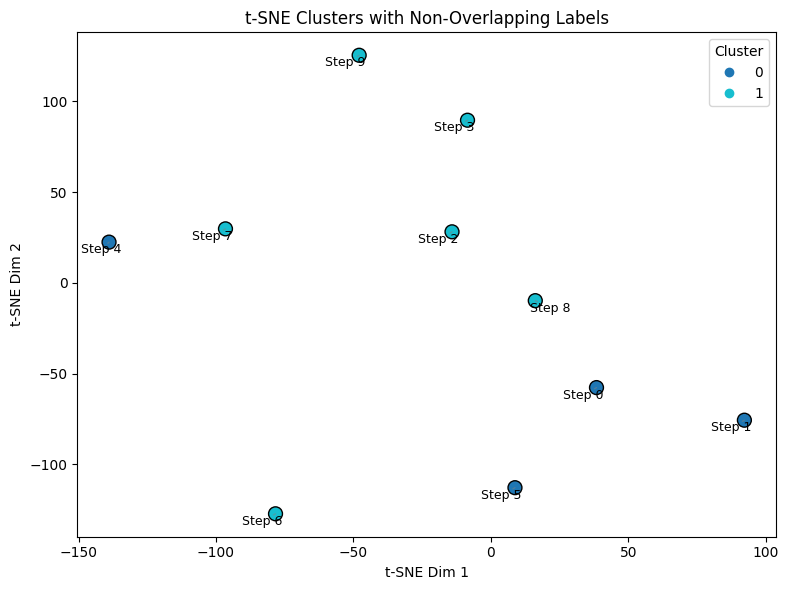

In [32]:
# Usage example:
visualize_clusters_tsne_with_adjusttext(centroids, df_clusters, perplexity=2)

In [33]:
import pandas as pd
from IPython.display import display

def detect_flow_by_cluster(df_clusters: pd.DataFrame) -> pd.DataFrame:
    """
    Label each turn as Start, Continuation, Callback, or Shift based on cluster assignments.

    Parameters:
        df_clusters (pd.DataFrame):
            DataFrame with columns ['Turn', 'Cluster'] in chronological order.

    Returns:
        pd.DataFrame:
            Columns: ['Turn', 'Cluster', 'Flow', 'Reference_Turn']
    """
    turns = df_clusters['Turn'].tolist()
    clusters = df_clusters['Cluster'].tolist()
    N = len(turns)

    records = []
    block_start = 0  # index of the first turn in the current continuation block

    for t in range(N):
        turn = turns[t]
        current_cluster = clusters[t]

        if t == 0:
            flow = 'Start'
            ref_turn = None
        else:
            prev_cluster = clusters[t-1]
            if current_cluster == prev_cluster:
                # Same cluster as previous turn
                flow = 'Continuation'
                ref_turn = turns[t-1]
            else:
                # Look for callback in turns before block_start
                candidates = [i for i in range(block_start) if clusters[i] == current_cluster]
                if candidates:
                    # Callback to the most recent occurrence before block_start
                    j = max(candidates)
                    flow = f'Callback to {turns[j]}'
                    ref_turn = turns[j]
                else:
                    # New cluster -> Shift
                    flow = 'Shift'
                    ref_turn = None
                    block_start = t  # start new continuation block

        records.append({
            'Turn': turn,
            'Cluster': current_cluster,
            'Flow': flow,
            'Reference_Turn': ref_turn
        })

    df_flow = pd.DataFrame(records)
    display(df_flow)
    return df_flow

# Example usage:
df_flow_cluster = detect_flow_by_cluster(df_clusters)

,Turn,Cluster,Flow,Reference_Turn
0,Step 0,0,Start,None
1,Step 1,0,Continuation,Step 0
2,Step 2,1,Shift,None
3,Step 3,1,Continuation,Step 2
4,Step 4,0,Callback to Step 1,Step 1
5,Step 5,0,Continuation,Step 4
6,Step 6,1,Shift,None
7,Step 7,1,Continuation,Step 6
8,Step 8,1,Continuation,Step 7
9,Step 9,1,Continuation,Step 8


In [34]:
process_queries_by_flow(query, df_flow_cluster)


Start at Step 0: 1. What is the purpose of tokenizing text into sentences and words?

Shift window centered at Step 2:
  Step 1: 2. What are n-gram language models and how are they useful in NLP?
  Step 2 (center): 3. What is the naive Bayes assumption and how does it relate to text classificatIon?
  Step 3: 4. What are some of the advantages and disadvantages of naive Bayes classifiers compared to logistic regression?

Callback at Step 4: 5. What do we mean by "features" in the context of text classification? Give some examples of features that might be useful for distinguishing different newsgroup topics.
  references Step 1: 2. What are n-gram language models and how are they useful in NLP?

Shift window centered at Step 6:
  Step 5: 6. What is the purpose of a test set in machine learning? Why do we need separatetraining and test sets?
  Step 6 (center): 7. What metrics could you use to evaluate the performance of a text classification model? Define accuracy and any other relevant